### EL CONJUNTO DE DATOS DE LOS PRECIOS DE LAS CASAS DE BOSTON

Vamos a intentar predecir el precio medio de las casas en un barrio de Boston determinado
a mediados del 70 considerando puntos de datos sobre el barrio en aquella epoca, como
indice de criminalidad, el impuesto sobre la propiedad local, etc.

El conjunto de datos que vamos a utilizar tiene una diferencia interesante respecto a los 2 anteriores.
Tiene relativamente pocos puntos de datos solo 506 divididos entre 404 muestras de entrenamiento y
102 muestras de prueba.
Cada caracteristica en los datos de entrada(por ejemplo el indice de criminalidad) tiene una escala
diferente. 

In [2]:
#Cargar el conjunto de datos

from keras.datasets import boston_housing
(train_data,train_labels),(test_data,test_labels)=boston_housing.load_data()

65536/57026 [==================================] - 0s 0us/step


In [4]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

Como vemos tenemos 404 muestras de entrenamiento y 102 muestras de prueba, cada una
con 13 caracteristicas numericas.

**Los objetivos son los valores medios de las casas ocupadas por los propietarios, en miles de dolares**

In [8]:
train_labels

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

In [10]:
import numpy as np
max,min=np.max(train_labels),np.min(train_labels)
print(max)
print(min)

50.0
5.0


Los precios estan entre 5 mil y 50 mil dolares.

#### PREPARAR LOS DATOS

Causaria muchos problemas introducir en una red neuronal valores que tomasen rangos
muy diferentes. Puede que la red fuese capaz de adaptar de forma automatica unos datos tan
heterogeneos, pero el aprendizaje resultaria mucho mas dificil. 

Una buena practica muy extendida para tratar este tipo de datos es la normalizacion en relacion a las caracteristicas:
    para cada caracteristica en los datos de entrada(una columna en la matriz de los datos de entrada),
    restamos la media de la caracteristica y dividimos entre la desviacion estandar de manera que la
    caracteristica quede centrada en 0 con desviacion estandar de 1.

In [14]:
#Normalizar los datos

mean=train_data.mean(axis=0) #pongo eje 0 para que haga el calculo por columna
train_data-=mean

std=train_data.std(axis=0)
train_data/=std
#observe que las cantidades utilizadas para normalizar los datos de prueba se computan utilizando los datos de entrenamiento.
#Nunca deberiamos utilizar en nuestro flujo de trabajo una cantidad computada en los datos de prueba, ni siquiera
#para algo tan simple como la normalizacion de datos.
test_data-=mean
test_data/=std

#### CREAR LA RED

Puesto que hay pocas instancias disponibles, vamos a utilizar una red muy chica con 2 capas ocultas,
cada una con 64 unidades. En general, cuantos menos datos de entrenamiento tengamos, peor sera 
el sobreajuste y utilizar una red pequena es una forma de reducir el sobreajuste

In [23]:
#Definicion del modelo

from keras import models
from keras import layers

#como hay que utilizar instancias del mismo modelo varias veces es mejor crear una funcion
def build_model():
    model=models.Sequential()
    model.add(layers.Dense(64,activation='relu',input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])
    return model

La red acaba con una sola unidad y sin activacion(sera una capa lineal). Esta es una configuracion
tipica para la regresion escalar. Aplicar una funcion de activacion limitaria el rango de valores que 
puede tomar la salida. Aqui puesto que la ultima capa es lineal, la red es libre de aprender a predecir
valores en cualquier rango.

Observe que compilamos la red con la funcion de perdida mse, que es el cuadrado de la diferencia entre
las predicciones y los objetivos. Esta funcion de perdida se utiliza mucho para problemas de regresion.

Tambien vamos a monitorizar una nueva metrica durante el entrenamiento: el error absoluto medio(mae)

Por ej un mae de 0.5 significaria que nuestras predicciones se desvian 500 dolares de media.


#### VALIDAR NUESTRO ENFOQUE USANDO VALIDACION CRUZADA

Para evaluar nuestra red mientras seguimos ajustando sus hiperparametros(como el epochs),
podriamos dividir los datos en conjunto de entrenamiento y validacion, como hechos hecho en
los ejemplos anteriores.

Pero como tenemos tan pocos puntos de datos el conjunto de validacion acabaria siendo muy pequeno(por ej 100 ejemplos).
En consecuencia las puntuaciones de validacion podrian cambiar mucho dependiendo de que puntos de datos decidamos utilizar 
para la validacion y cuales elijamos para el entrenamiento: las puntuaciones de validacion podrian tener una varianza
alta con respecto a la division de validacion. Eso impediria que evaluasemos el modelo de manera fiable.

Los mas adecuado en estas situaciones es utilizar validacion cruzada de K iteraciones. Consiste en dividir
los datos disponibles en K particiones utilizando instancias de K modelos identicos y entrenando cada uno
en K-1 particiones mientras se evalua la particion restante. 

La puntuacion de validacion para el modelo utilizado sera entonces la media de las puntuaciones de las K
validaciones obtenidas.


In [24]:
#AQUI VA EL CODIGO

import numpy as np

k=4

num_val_samples=len(train_data)//k
num_epochs=100
all_scores=[]

for i in range(k):
    print('processing fold #',i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_data_labels=train_labels[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate([train_data[:i*num_val_samples],
                                      train_data[(i+1)*num_val_samples:]],
                                     axis=0)
    
    partial_train_labels=np.concatenate([train_labels[:i*num_val_samples],
                                        train_labels[(i+1)*num_val_samples:]],
                                       axis=0)
    
    model=build_model()
    model.fit(partial_train_data,partial_train_labels,
             epochs=num_epochs,batch_size=1,verbose=0)
    val_mse,val_mae=model.evaluate(val_data,val_data_labels,verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [25]:
all_scores

[1.9206026792526245,
 2.3369388580322266,
 2.5221776962280273,
 2.4304513931274414]

In [26]:
np.mean(all_scores)

2.30254265666008

Las diferentes ejecuciones muestran puntuaciones de validacion diferentes desde 1.9 a 2.52. La media 2.3 es una 
metrica mucho mas fiable que cualquier puntuacion individual: esa es la clave de K ITERACIONES.
En este caso nos desviamos de una media en 2300 dolares lo cual es bastante si consideramos que los precios van
de 5000 a 50.000 dolares


Probemos en entrenar la red un poco mas por ej 500 epocas.
Para mantener un registro de lo bien que funciona el modelo en cada repeticion, vamos
a modificar el bucle de entrenamiento para guardar el registro de puntuacion de la 
validacion por repeticion.

In [30]:

k=4

num_val_samples=len(train_data)//k
num_epochs=500
all_mae_histories=[]

for i in range(k):
    print('processing fold #',i)
    val_data=train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_data_labels=train_labels[i*num_val_samples:(i+1)*num_val_samples]
    
    partial_train_data=np.concatenate([train_data[:i*num_val_samples],
                                      train_data[(i+1)*num_val_samples:]],
                                     axis=0)
    
    partial_train_labels=np.concatenate([train_labels[:i*num_val_samples],
                                        train_labels[(i+1)*num_val_samples:]],
                                       axis=0)
    
    model=build_model() #crea el modelo ya compilado en keras
    history=model.fit(partial_train_data,partial_train_labels,
                      validation_data=(val_data,val_data_labels),
                      epochs=num_epochs,batch_size=1,verbose=0)
    mae_history=history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [32]:
#A continuacion podemos computar la media de las puntuaciones MAE por repeticion para todas las iteraciones.
average_mae_history=[np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

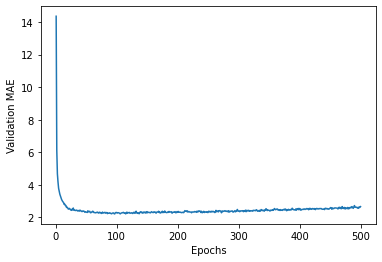

In [34]:
import matplotlib.pyplot as plt

plt.plot(range(1,len(average_mae_history)+1),average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Puede que resulte un poco dificil ver el grafico debido a los problemas de escala y la varianza
relativamente alta. Vamos a hacer lo siguiente:
    
    -Omitiremos los 10 primeros puntos de datos, que estan en una escala diferente al resto de la curva.
    -Sustituiremos cada punto con una media movil exponencial de los puntos anteriores para obtener una
    curva fluida.

In [35]:
def smooth_curve(points,factor=0.9):
    smoothed_points=[]
    for point in points:
        if smoothed_points:
            previous=smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


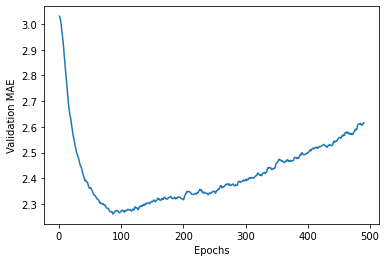

In [36]:
smooth_mae_history=smooth_curve(average_mae_history[10:])

plt.plot(range(1,len(smooth_mae_history)+1),smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Segun este grafico el EAM de validacion deja de mejorar de manera significativa despues de 80 repeticiones

Una vez que acabamos de ajustar otros parametros del modelo(ademas del numero de repeticiones,podriamos ajustar
tambien el tamano de las capas ocultas), podemos entrenar un modelo de produccion final en todos los datos de 
entrenamiento, con los mejores parametros y despues observar su rendimiento en los datos de prueba.

In [47]:
np.argmin(smooth_mae_history) # en la iteracion 86 logra el minimo

86

In [53]:
#Entrenar el modelo final

model=build_model()
model.fit(train_data,train_labels,
         epochs=86,batch_size=16,verbose=0)
test_mse_score,test_mae_score=model.evaluate(test_data,test_labels)

4/4 [==============================] - 0s 665us/step - loss: 21.5200 - mae: 2.9859


In [54]:
test_mae_score

2.9859018325805664

La desviacio aun es grande 2980 dolares